The goal of this notebook is to explore multiple regression and feature engineering Sklearn functions.

In this notebook you will use data on house sales in California to predict prices using multiple regression. 

You will:
* Train multiple regression models 
* Inspect coefficients and interpret their meanings
* Evaluate multiple models via RMSE, MAE, and R2
* Use Cross validation to regularize weights to shrink coefficients of features not useful for predicting housing prices

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Import in house data

In [110]:
df = pd.read_csv('../datasets/housing_paml_hw2.csv')

In [111]:
df.dropna(inplace=True)

In [113]:
features=['ocean_proximity']
encoded_feature=df[features]
encoded_feature_df = pd.DataFrame({'ocean_proximity': df[features[0]]})
for feat in features:
    df = pd.get_dummies(df, columns=[feat])
print(df.columns)
print(encoded_feature_df)
df = df.join(encoded_feature_df)
print(df.head())
#df = df.append(encoded_feature)

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'city', 'postcode', 'county', 'road',
       'rooms_per_household', 'number_bedrooms', 'number_bathrooms',
       'ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN'],
      dtype='object')
      ocean_proximity
0            NEAR BAY
1            NEAR BAY
2            NEAR BAY
3            NEAR BAY
6            NEAR BAY
...               ...
20503       <1H OCEAN
20504       <1H OCEAN
20505       <1H OCEAN
20506       <1H OCEAN
20523          INLAND

[10684 rows x 1 columns]


In [114]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,postcode,rooms_per_household,number_bedrooms,number_bathrooms,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
count,10684.000000,10684.000000,10684.000000,10684.000000,10684.000000,10684.000000,10684.000000,10684.000000,10684.000000,10684.000000,10684.000000,10684.000000,10684.000000,10684.000000,10684.000000,10684.000000,10684.000000
mean,-119.288341,35.201291,30.001872,2592.112411,548.318514,1482.061868,521.131692,3.775697,205899.883939,92572.881411,5.054429,1.757207,3.796799,0.536597,0.234463,0.083396,0.145545
std,1.872055,1.951984,12.558108,2181.783511,435.523778,1166.079336,418.359918,1.797194,107448.502189,3256.256050,1.268650,0.435936,1.366748,0.498682,0.423682,0.276492,0.352666
min,-124.190000,32.540000,1.000000,12.000000,3.000000,3.000000,4.000000,0.499900,17500.000000,1387.000000,0.125800,1.000000,-0.000000,0.000000,0.000000,0.000000,0.000000
25%,-121.430000,33.870000,20.000000,1437.000000,299.000000,812.750000,291.000000,2.503350,127200.000000,91214.000000,4.216465,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000
50%,-118.370000,34.150000,31.000000,2082.500000,442.000000,1201.000000,423.000000,3.515850,182700.000000,92503.000000,4.981449,2.000000,4.000000,1.000000,0.000000,0.000000,0.000000
75%,-117.970000,37.340000,39.000000,3071.000000,658.000000,1783.250000,619.000000,4.693325,258950.000000,94536.000000,5.783019,2.000000,5.000000,1.000000,0.000000,0.000000,0.000000
max,-115.510000,40.880000,52.000000,39320.000000,6445.000000,28566.000000,6082.000000,15.000100,500001.000000,99262.000000,24.500000,7.000000,18.000000,1.000000,1.000000,1.000000,1.000000


# Linear Regression from scratch

In [65]:
# Hypothetical function h(x)  
def predict(X, W): 
    #W=W.reshape(-1,1)
    num_examples, _ = X.shape
    X_transform = np.append(np.ones((num_examples, 1)), X, axis=1)
    prediction = X_transform.dot(W) 
    return prediction

In [66]:
def standardize(X_transform, num_features):
    means = np.mean(X_transform, axis=0) #columnwise mean and std
    stds = np.std(X_transform, axis=0)+1e-7
    X_normalized = (X_transform-means)/(stds)
    return X_transform

In [67]:
# Update weights in gradient descent 
from sklearn.metrics import mean_squared_error

def update_weights(X, Y, W, lr): 
    # m: no_of_training_examples, n:no_of_features 
    num_examples, _ = X.shape
    X_transform = np.append(np.ones((num_examples, 1)), X, axis=1)
    
    # Make prediction using fitted line
    Y_pred = predict(X, W) 
      
    # calculate gradients using RMSE: RMSE = sqrt((1/n)sum_{num_examples} error^2) 
    # derivative wrt w
    dW = - (2 * (X_transform.T).dot(Y - Y_pred) ) / num_examples

    cost = mean_squared_error(Y, Y_pred, squared=False)
      
    # update weights 
    W = W - lr * dW 
    return W, cost

In [68]:
def fit(X, Y, lr, num_iterations=100): 
    #num_examples, num_features
    _, num_features = X.shape
    
    # weight initialization 
    W = np.zeros(num_features + 1) # +1 for const offset 

    cost_hist=[]
    # Run Gradient Descent 
    for _ in range(num_iterations): 
        W, cost = update_weights(X, Y, W, lr) 
        cost_hist.append(cost)
    return W, cost_hist

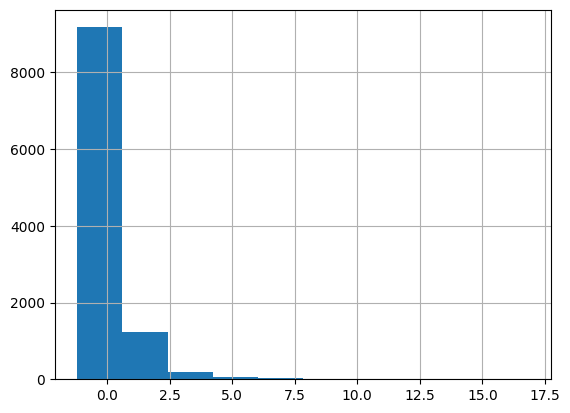

In [69]:
# Normalization or Standardization
df['total_rooms_std'] = (df['total_rooms'] - df['total_rooms'].mean())/df['total_rooms'].std()
df['total_rooms_std'].hist()

df['total_rooms_norm']=(df['total_rooms']-df['total_rooms'].min())/(df['total_rooms'].max()-df['total_rooms'].min())
df['population_norm']=(df['population']-df['population'].min())/(df['population'].max()-df['population'].min())
#df['total_rooms_norm'].hist()

In [70]:
feature_input_select = ['total_rooms_std']#,'total_rooms_norm','population_norm']
X = df.loc[:, df.columns.isin(feature_input_select)]

X = np.reshape(X, (X.shape[0],len(feature_input_select)))

y = np.asarray(df['median_house_value'].values.tolist()) 

In [71]:
print(X.shape)
print(y.shape)

(10684, 1)
(10684,)


In [72]:
# Splitting dataset into train and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=0)

In [73]:
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))
print(len(X_train)/(len(X_train)+len(y_test)))
print(len(X_test)/(len(X_train)+len(y_test)))

10149
535
10149
535
0.9499251216772744
0.05007487832272557


In [74]:
# Linear Regression Parameters
lr_learning_rate = 0.01
num_iterations = 500
X = X_train
Y = y_train

Train linear regression model

In [75]:
lr_W, lr_cost = fit(X_train, y_train, lr_learning_rate, num_iterations=num_iterations) 

Inspect model weights

In [76]:
print('Weights: {}'.format(lr_W))

Weights: [205785.16681287  12972.15872824]


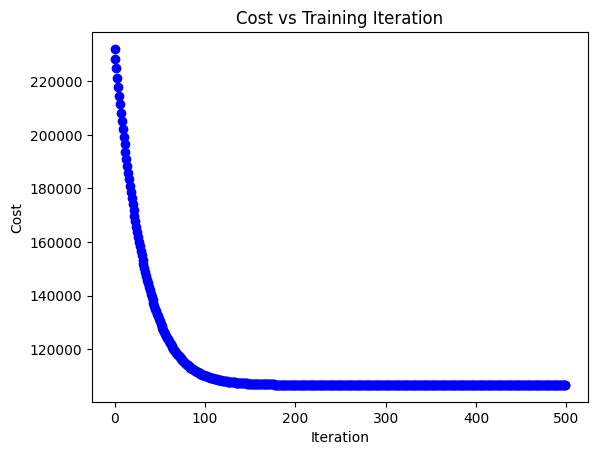

In [77]:
plt.scatter(np.arange(0,len(lr_cost),1), lr_cost, color = 'blue') 
plt.title('Cost vs Training Iteration') 
plt.xlabel('Iteration') 
plt.ylabel('Cost') 
plt.show() 

In [78]:
y_pred = predict(X_test, lr_W) 
print("Predicted values ", np.round(y_pred, 2))  
print("Real values      ", y_test) 
print("Linear Regression Coefficients W        ", np.round(lr_W, 2)) 

Predicted values  [212366.35 195456.87 203435.96 198661.59 204268.35 199285.88 213210.64
 205986.65 202288.45 202520.33 195409.31 200035.04 207027.14 211284.24
 199178.86 200867.43 206807.15 205677.48 200754.46 198049.19 210761.02
 199987.47 194707.72 195213.1  216974.24 200118.28 190694.4  199095.62
 197531.91 200736.63 203869.99 213115.51 262482.38 217705.56 208477.89
 201681.99 238604.58 204708.33 199184.81 200683.12 200290.7  204036.47
 196152.52 204779.68 196764.92 239734.26 200724.74 198423.76 191883.53
 206402.85 191116.54 195807.67 218407.15 203293.26 204654.82 207484.96
 199458.31 194844.47 213157.13 200171.79 237564.09 219602.23 214691.11
 200760.41 202068.46 191550.57 195320.12 200558.26 199178.86 202722.48
 214263.02 213496.03 211575.58 215678.09 196164.41 212312.84 198917.25
 193375.89 203792.7  197585.42 207788.19 215731.6  197674.61 206622.84
 206236.37 215220.27 202246.83 209613.51 202234.94 196330.89 199493.98
 210118.89 202835.45 206926.07 192935.91 202300.34 197870.8

Inspect model coefficient

Visualization on test set  

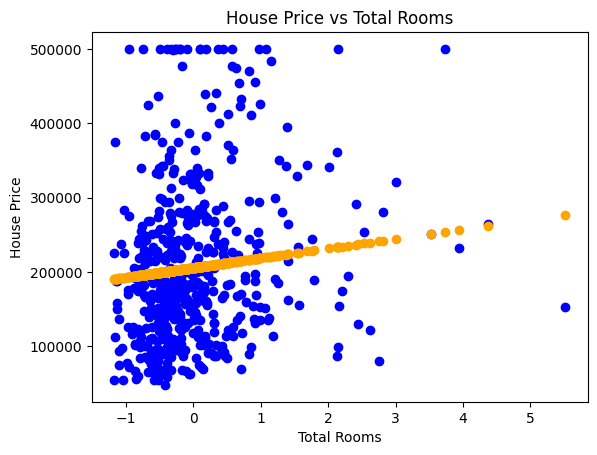

In [79]:
plt.scatter(X_test[feature_input_select[0]], y_test, color = 'blue') 
plt.scatter(X_test[feature_input_select[0]], y_pred, color = 'orange') 
plt.title('House Price vs Total Rooms') 
plt.xlabel('Total Rooms') 
plt.ylabel('House Price') 
plt.show() 

In [80]:
'''
plt.scatter(X_test[feature_input_select[1]], y_test, color = 'blue') 
plt.scatter(X_test[feature_input_select[1]], y_pred, color = 'orange') 
plt.title('House Price vs Total Rooms') 
plt.xlabel('Total Rooms') 
plt.ylabel('House Price') 
plt.show() 
'''

"\nplt.scatter(X_test[feature_input_select[1]], y_test, color = 'blue') \nplt.scatter(X_test[feature_input_select[1]], y_pred, color = 'orange') \nplt.title('House Price vs Total Rooms') \nplt.xlabel('Total Rooms') \nplt.ylabel('House Price') \nplt.show() \n"

In [81]:
X_test

,total_rooms_std
18906,0.507332
18710,-0.796189
14581,-0.181096
3508,-0.549144
13097,-0.116928
...,...
11885,-0.572977
6533,0.128742
4526,-0.659604
8253,0.156243


### Evaluate Regression Models

Root mean squared error (RMSE) measures the average difference between values predicted by a model and the actual values. It provides an estimation of how well the model is able to predict the target value (accuracy).

$$
RMSE = \sqrt{\sum_{i}^{N}\frac{(y_i - f(x_i))^2}{N}}
$$

Where 
* N is the number of examples
* $y_i$ is the actual house price 
* f($x_i$) is the predicted house price using feature $x_i$

In [82]:
def rmse(y_true, y_pred):
    error = np.sqrt(np.sum(np.power(y_pred-y_true,2))/len(y_true))
    return error

In [83]:
rmse_error = rmse(y_test, y_pred)
print(rmse_error)

106931.50671995475


In [84]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_test, y_pred, squared=False)) # squared=False for RMSE

106931.50671995475


Mean Absolute Error (MAE) is defined as the average variance between the significant values in the dataset and the projected values in the same dataset.

$$
MAE = \sum_{i}^{N} \frac{|y_i - f(x_i)|}{N}
$$

Where 
* N is the number of examples
* $y_i$ is the actual house price 
* f($x_i$) is the predicted house price using feature $x_i$

In [85]:
def mae(y_true, y_pred):
    error = (np.sum(np.abs(y_pred-y_true))) / len(y_true)
    return error

In [86]:
mae_error = mae(y_test[:3], y_pred[:3])
print(mae_error)

70686.39548349378


In [87]:
mae_error = mae(y_test, y_pred)
print(mae_error)

82693.32252831405


In [88]:
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y_test, y_pred))

82693.32252831405


Coefficient of determination

The coefficient of Determination ($R^2$)is a measure that provides information about the goodness of fit of a model. In the context of regression it is a statistical measure of how well the regression line approximates the actual data. It is therefore important when a statistical model is used either to predict future outcomes or in the testing of hypotheses.
$$
R^2 = 1 - \frac{RSS}{TSS}
$$

Total Sum of Squares (TSS) is the sum of all squared differences between the mean of a sample and the individual values in that sample. It is represented mathematically with the formula:

$$
TSS = \sum_{i=1}^{N} (y_i - \bar{y})^2
$$

Where 
* N is the number of examples
* $y_i$ is input sample
* $\bar{y}$ is mean of input y

The residual sum of squares (RSS) measures the level of variance in the error term, or residuals, of a regression model. The smaller the residual sum of squares, the better your model fits your data; the greater the residual sum of squares, the poorer your model fits your data with the formula:
$$
RSS = \sum_{i=1}^{N} (y_i - f(x_i))^2 
$$

Where 
* N is the number of examples
* $y_i$ is the actual house price
* f($x_i$) is the predicted house price using feature $x_i$

In [89]:
def r2_score(y_test, y_pred):
    tss = np.sum(np.power(y_test - np.mean(y_pred),2))
    rss = np.sum(np.power(y_test - y_pred,2))
    r2 = 1 - (rss/tss)
    return r2

In [90]:
r2_error = r2_score(y_test[:3], y_pred[:3])
print(r2_error)

0.020608283072785727


An R-Squared value shows how well the model predicts the outcome of the dependent variable. R-Squared values range from 0 to 1. An R-Squared value of 0 means that the model explains or predicts 0% of the relationship between the dependent and independent variables.

In [91]:
r2_error = r2_score(y_test, y_pred)
print(r2_error)

0.027379585590405098


In [92]:
from sklearn.metrics import r2_score
print(r2_score(y_test, y_pred))

0.027003805852680918


### Learning Curves

In [93]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [94]:
def print_info(mode, y_true, y_pred, print_results=True):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    if(print_results):
        print(mode + ": RMSE: {0}, MAE: {1}, R2: {2}".format(rmse,mae,r2))
    return rmse, mae, r2

In [95]:
print_info('test', y_test[:3], y_pred[:3], print_results=True)

test: RMSE: 82923.25101628163, MAE: 70686.39548349378, R2: -2.3967117666227544


(82923.25101628163, 70686.39548349378, -2.3967117666227544)

In [96]:
def plot_learning_curves(X_train, X_val, y_train, y_val, lr_W, lr=0.001):
    train_rmse_errors, train_mae_errors, train_r2_errors = [], [], []
    val_rmse_errors, val_mae_errors, val_r2_errors = [], [], []
    for m in range(1, len(X_train) + 1, 15):
        lr_W, cost = fit(X_train[:m], y_train[:m], lr)
        y_train_predict = predict(X_train[:m], lr_W)
        y_val_predict = predict(X_val, lr_W)
        
        train_rmse, train_mae, train_r2 = print_info("train", y_train[:m], y_train_predict, print_results=False)
        train_rmse_errors.append(train_rmse)
        train_mae_errors.append(train_mae)
        train_r2_errors.append(train_r2)
        
        val_rmse, val_mae, val_r2 = print_info("test", y_val, y_val_predict, print_results=False)
        val_rmse_errors.append(val_rmse)
        val_mae_errors.append(val_mae)
        val_r2_errors.append(val_r2)
    result = {'train_rmse_errors':train_rmse_errors, 
           'train_mae_errors':train_mae_errors, 
           'train_r2_errors':train_r2_errors, 
           'val_rmse_errors':val_rmse_errors, 
           'val_mae_errors':val_mae_errors, 
           'val_r2_errors':val_r2_errors}
    return result 

In [97]:
def plot_lc_figures(error1, error2, metric=''):
    plt.plot(error1, "r-+", linewidth=2, label="train")
    plt.plot(error2, "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   # not shown in the book
    plt.xlabel("Training set size", fontsize=14) # not shown
    plt.ylabel(str(metric).upper(), fontsize=14)              # not shown

In [98]:
errors  = plot_learning_curves(X_train, X_test, y_train, y_test, lr_W, lr=lr_learning_rate)

/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


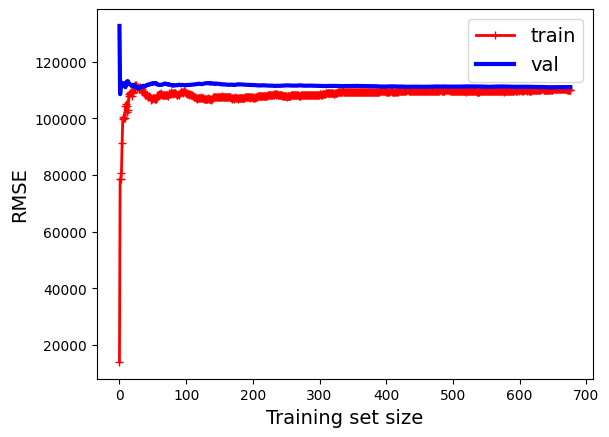

In [99]:
plot_lc_figures(errors['train_rmse_errors'], errors['val_rmse_errors'], metric='RMSE')

### Impact of learning rate

In [100]:
weights_list=[]
cost_list=[]
for lr in range(1,10,1):
    print((lr)/10)
    learning_rate=lr/10
    weights, cost = fit(X_train, y_train, learning_rate, num_iterations=100)
    weights_list.append(weights)
    cost_list.append(np.mean(cost))

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


In [101]:
np.arange(0,len(cost_list),1)/10

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])

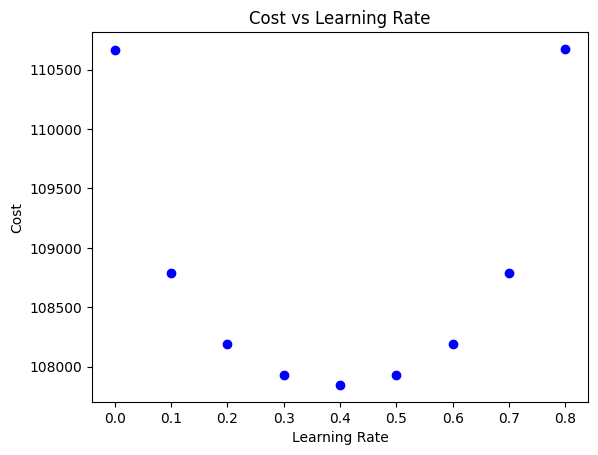

In [102]:
plt.scatter(np.arange(0,len(cost_list),1)/10, cost_list, color = 'blue') 
plt.title('Cost vs Learning Rate') 
plt.xlabel('Learning Rate') 
plt.ylabel('Cost') 
plt.show() 

### Impact of number of iterations

In [103]:
weights_list=[]
cost_list=[]
learning_rate=0.5
for num_iterations in range(0,710,10):
    weights, cost = fit(X_train, y_train, learning_rate, num_iterations=num_iterations)
    weights_list.append(weights)
    cost_list.append(np.mean(cost))

/opt/homebrew/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [104]:
np.arange(0,len(cost_list),1)*10

array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
       130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250,
       260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380,
       390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510,
       520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640,
       650, 660, 670, 680, 690, 700])

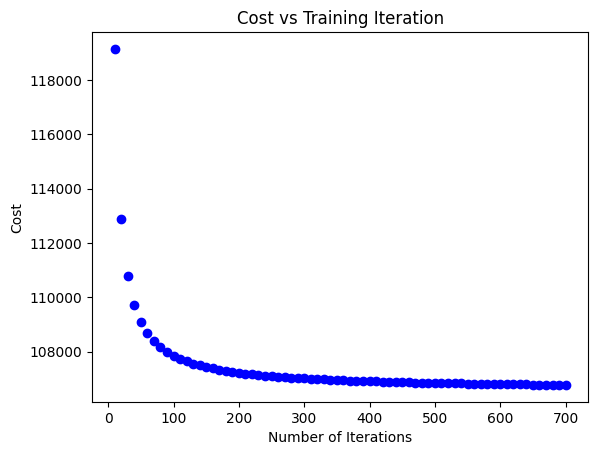

In [105]:
plt.scatter(np.arange(0,len(cost_list),1)*10, cost_list, color = 'blue') 
plt.title('Cost vs Training Iteration') 
plt.xlabel('Number of Iterations') 
plt.ylabel('Cost') 
plt.show() 